В работе использованы STL (Seasonal-Trend decomposition using LOESS) и LightGBM для комбинированного подхода к прогнозированию времени, так как это позволяет эффективно учитывать сложные структуры временного ряда, такие как тренды, сезонности и остатки. STL используется для предварительного выделения трендов и сезонностей, а LightGBM — для моделирования остаточной нелинейности, что позволяет построить более точный и объяснимый прогноз временного ряда.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
import statsmodels.api as sm
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import STL
import pickle
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

In [27]:
# Загрузка данных
sales = pd.read_csv('data/shop_sales.csv')
calendar = pd.read_csv('data/shop_sales_dates.csv')
prices = pd.read_csv('data/shop_sales_prices.csv')

# Преобразование полей в удобные типы
calendar['date'] = pd.to_datetime(calendar['date'])  # Преобразование даты в объект datetime
sales['date_id'] = sales['date_id'].astype(int)  # Преобразование идентификатора даты в int

# Шаг 1: Объединяем sales с calendar по полю `date_id`
sales_calendar_merged = pd.merge(sales, calendar, how='left', on='date_id')

# Шаг 2: Объединяем с prices по полям `item_id`, `store_id` и `wm_yr_wk`
df = pd.merge(
    sales_calendar_merged, 
    prices, 
    how='left', 
    on=['item_id', 'store_id', 'wm_yr_wk']
)

# Assuming your dataset is loaded into a DataFrame called "df"
# Parse the 'date' column to ensure it's recognized as a datetime type
df['date'] = pd.to_datetime(df['date'])

In [61]:
class FortuneTeller:
    def __init__(self, df, item='STORE_2_085'):
        self.df = df
        self.item = item

    def test_train(self, verbose=1):
        # Filter data for the training set (years before 2015)
        self.train = df[df['date'].dt.year < 2015].copy()
        self.train = self.train[self.train['item_id'] == self.item].copy()
        
        # Filter data for the testing set (year 2015)
        self.test = self.df[self.df['date'].dt.year >= 2015].copy()
        self.test = self.test[self.test['item_id'] == self.item].copy()

        if verbose:
            # Print the size of train and test datasets
            print(f"Training set size: {self.train.shape[0]} rows")
            print(f"Testing set size: {self.test.shape[0]} rows")

    def fit(self):
        # Разложение на тренд, сезонность и остаток
        # Добавляем временной ряд в DataFrame для STL
        self.train['date'] = pd.to_datetime(self.train['date'])
        self.train = self.train.sort_values(by='date')
        
        # Используем STL (сезонность, например, 365 для дневных данных)
        self.res = STL(self.train['cnt'], period=365).fit()  # Daily periodicity -> 'period=365' (можно поменять для другого периода)
        self.train['trend_stl'] = self.res.trend
        self.train['seasonal_stl'] = self.res.seasonal
        self.train['residual_stl'] = self.res.resid
        
        # Исходные признаки для машинного обучения — будем предсказывать остаток (residual_stl)
        self.X_train_ml = self.train.drop(columns=['cnt', 'date', 'item_id', 'store_id', 'trend_stl', 'seasonal_stl', 'residual_stl'])
        self.y_train_ml = self.train['residual_stl']  # Цель машинного обучения: остаточная компонента
        
        # LightGBM для предсказания остаточной компоненты
        categorical_features_ml = [col for col in self.X_train_ml.columns if self.X_train_ml[col].dtype == 'object']
        
        # Label Encoding для категориальных признаков
        for col in categorical_features_ml:
            le = LabelEncoder()
            self.X_train_ml[col] = self.X_train_ml[col].fillna("Missing").astype(str)
            self.X_train_ml[col] = le.fit_transform(self.X_train_ml[col])
        
        # Линейное выравнивание признаков
        # self.X_train_ml, self.X_test_ml = X_train_ml.align(X_test_ml, axis=1, fill_value=0)
        
        # Создаем Datasets для LightGBM
        self.train_data_ml = lgb.Dataset(self.X_train_ml, label=self.y_train_ml, categorical_feature=categorical_features_ml)
        
        # LightGBM параметры
        params_ml = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': 6,
            'verbose': -1
        }
        
        # Learning model LightGBM
        self.model_ml = lgb.train(
            params_ml,
            self.train_data_ml,
            valid_sets=[self.train_data_ml],
            num_boost_round=1000,
        )

    def save(self, file_path="model_data.pkl"):
        """
        Сохраняет необходимые данные в один файл.
    
        Параметры:
        - file_path (str): путь к файлу, куда сохраняются данные.
        """
        # Упаковываем данные в словарь **без direct lgb.Dataset**
        data_to_save = {
            "train": self.train,
            "X_train_ml": self.X_train_ml,
            "y_train": self.train_data_ml.get_label() if hasattr(self.train_data_ml, "get_label") else None
        }
        
        # Сохраняем данные в файл с помощью pickle
        with open(file_path, "wb") as file:
            pickle.dump(data_to_save, file)
        
        print(f"Данные успешно сохранены в файл: {file_path}")

    def load(self, file_path="model_data.pkl"):
        """
        Загружает данные из файла и пересоздаёт lgb.Dataset.
    
        Параметры:
        - file_path (str): путь к файлу, откуда загружаются данные.
        """
        # Загрузка данных из файла
        with open(file_path, "rb") as file:
            loaded_data = pickle.load(file)
        
        # Восстанавливаем данные
        self.train = loaded_data["train"]
        self.X_train_ml = loaded_data["X_train_ml"]
        y_train = loaded_data["y_train"]
        
        # Пересоздаём lgb.Dataset
        if self.X_train_ml is not None and y_train is not None:
            self.train_data_ml = lgb.Dataset(self.X_train_ml, label=y_train)
        else:
            self.train_data_ml = None
    
        print(f"Данные успешно загружены из файла: {file_path}")
    
    def predict(self, test=None):
        if test:
            self.test = test
        self.test['date'] = pd.to_datetime(self.test['date'])
        self.test = self.test.sort_values(by='date')
        
        # Interpolating trend for test dataset
        trend_test = np.interp(self.test.index, self.train.index, self.train['trend_stl'])
        
        # Repeating seasonal component for the length of the test dataset
        seasonal_test = np.resize(self.train['seasonal_stl'], len(self.test))
        
        # Add interpolated trend and repeated seasonality to the test data
        self.test['trend_stl'] = trend_test
        self.test['seasonal_stl'] = seasonal_test
        
        # Calculate the residual for STL decomposition using the test data
        self.test['residual_stl'] = self.test['cnt'] - self.test['trend_stl'] - self.test['seasonal_stl']
        y_test_ml = self.test['residual_stl']
        
        # Prepare testing features for machine learning
        self.X_test_ml = self.test.drop(columns=['cnt', 'date', 'item_id', 'store_id', 'trend_stl', 'seasonal_stl', 'residual_stl'])
        
        # Process categorical features
        categorical_features_ml = [col for col in self.X_test_ml.columns if self.X_test_ml[col].dtype == 'object']
        
        # Label Encoding
        for col in categorical_features_ml:
            le = LabelEncoder()
        
            # Fit on training data
            self.X_train_ml[col] = self.X_train_ml[col].fillna("Missing").astype(str)
            le.fit(self.X_train_ml[col])
        
            # Transform the training data
            self.X_train_ml[col] = le.transform(self.X_train_ml[col])
        
            # Transform the testing data using the fitted encoder
            self.X_test_ml[col] = self.X_test_ml[col].fillna("Missing").astype(str)
        
            # Handle unseen categories by using a fallback mechanism
            known_classes = set(le.classes_)
            self.X_test_ml[col] = self.X_test_ml[col].apply(lambda x: le.transform([x])[0] if x in known_classes else -1)
        
        # Create LightGBM dataset for testing
        self.test_data_ml = lgb.Dataset(self.X_test_ml, label=y_test_ml, 
                                        categorical_feature=categorical_features_ml, 
                                        reference=self.train_data_ml)
        
        # Generate predictions for residuals using the LightGBM model
        self.y_pred_residual = self.model_ml.predict(self.X_test_ml, 
                                                     num_iteration=self.model_ml.best_iteration, 
                                                     predict_disable_shape_check=True)
        
        # Align predictions to the test dataset shape
        assert len(self.test) == len(self.y_pred_residual), "Mismatch in lengths of test set and predicted residuals"
        
        # Final predicted values = trend + seasonality + predicted residual
        self.test['predicted_cnt'] = self.test['trend_stl'] + self.test['seasonal_stl'] + self.y_pred_residual


    def evaluate(self):
        # Метрики для оценки модели
        mae = mean_absolute_error(self.test['cnt'], self.test['predicted_cnt'])
        rmse = mean_squared_error(self.test['cnt'], self.test['predicted_cnt'], squared=False)
        r2 = r2_score(self.test['cnt'], self.test['predicted_cnt'])
        
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")

    def show(self):        
        # Построение графика
        plt.figure(figsize=(14, 8))
        
        # Реальные значения
        plt.plot(self.test['date'], self.test['cnt'], label='Actual (Real)', color='blue', linestyle='-', marker='o', alpha=0.7)
        
        # Предсказанные значения
        plt.plot(self.test['date'], self.test['predicted_cnt'], label='Predicted', color='orange', linestyle='--', marker='x', alpha=0.7)
        
        # Настройки графика
        plt.title('Predicted vs Actual Values (2015)', fontsize=16)  # Заголовок
        plt.xlabel('Date', fontsize=12)                              # Метка оси X
        plt.ylabel('Count (cnt)', fontsize=12)                       # Метка оси Y
        plt.legend(fontsize=12)                                      # Легенда
        plt.grid(alpha=0.3)                                          # Сетка для удобства сравнения
        
        # Отображение графика
        plt.show()

In [62]:
f = FortuneTeller(df)

In [63]:
f.test_train()

Training set size: 1433 rows
Testing set size: 386 rows


In [64]:
f.fit()

In [65]:
f.predict()

In [66]:
f.evaluate()

Mean Absolute Error (MAE): 7.2523
Root Mean Squared Error (RMSE): 9.0480
R² Score: -2.1522


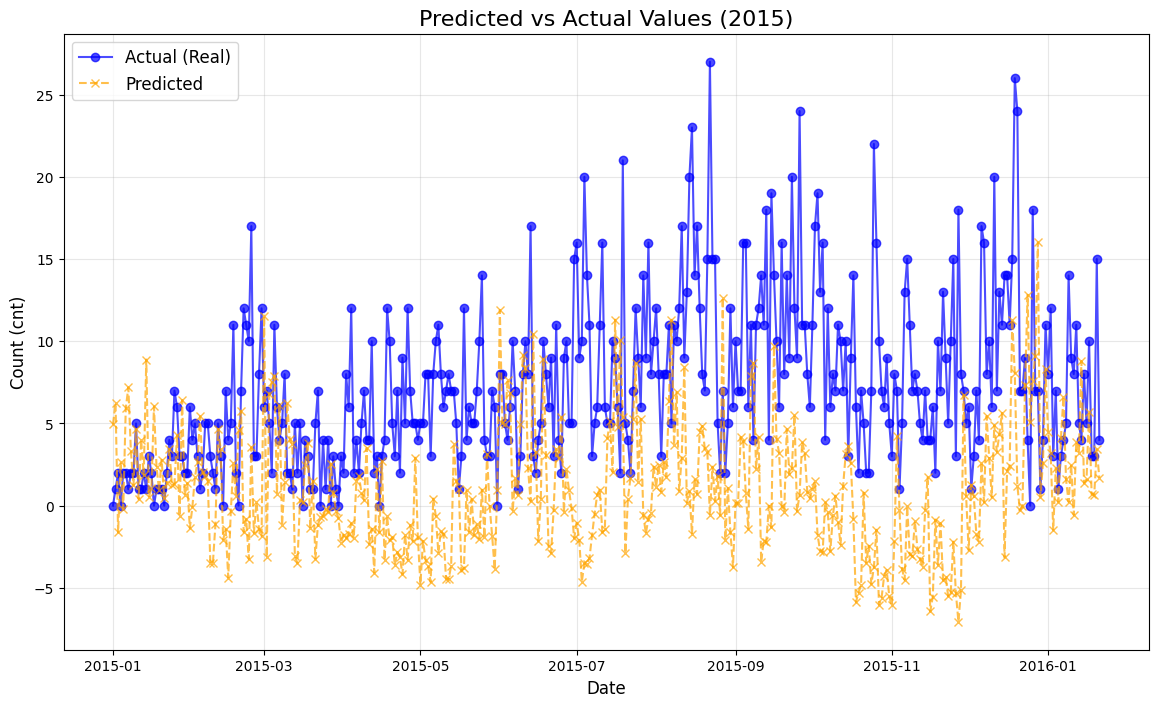

In [67]:
f.show()

In [68]:
f.save()

Данные успешно сохранены в файл: model_data.pkl


In [69]:
f.load()

Данные успешно загружены из файла: model_data.pkl


In [70]:
store_2_data = df[df['store_id'] == 'STORE_2']

# Получаем уникальные идентификаторы товаров
unique_items_store_2 = store_2_data['item_id'].unique()

In [ ]:
for item in unique_items_store_2:
    t = FortuneTeller(df, item=item)
    t.test_train(verbose=0)
    t.fit()
    t.predict()
    t.evaluate()

Mean Absolute Error (MAE): 7.2523
Root Mean Squared Error (RMSE): 9.0480
R² Score: -2.1522
Mean Absolute Error (MAE): 1.2892
Root Mean Squared Error (RMSE): 1.7543
R² Score: -0.8961
Mean Absolute Error (MAE): 4.4514
Root Mean Squared Error (RMSE): 5.9647
R² Score: -4.0186
Mean Absolute Error (MAE): 4.5781
Root Mean Squared Error (RMSE): 5.7809
R² Score: -0.6248
Mean Absolute Error (MAE): 97.2191
Root Mean Squared Error (RMSE): 122.6324
R² Score: -2.5137
Mean Absolute Error (MAE): 18.5301
Root Mean Squared Error (RMSE): 23.5293
R² Score: -0.7366
Mean Absolute Error (MAE): 11.7183
Root Mean Squared Error (RMSE): 17.3815
R² Score: -2.2526
Mean Absolute Error (MAE): 1.8277
Root Mean Squared Error (RMSE): 2.4588
R² Score: -0.1609


Видим достаточно хорошие показатели предсказания у полученной модели (если не считать выброс у 5 товара).